In [1]:
import pandas as pd
import glob
import tensorflow as tf
from tensorflow.data import Dataset
from matplotlib import pyplot
from tensorflow.keras.callbacks import TensorBoard
import numpy as np

2021-10-21 13:47:08.557905: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-21 13:47:08.557945: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df_23043 = pd.read_csv("../data/datasets_by_whale/1999CA-Bmu-23043.csv")[["location-long", "location-lat"]] 
#whale with largest route

### Split data for train and test 

In [3]:
def split_data(df):

    n = len(df)
    train_df = df[0:int(n*0.7)]
    test_df = df[int(n*0.7):]

    num_features = df.shape[1]
    
    return train_df,test_df

In [4]:
train_df,test_df = split_data(df_23043)

### Create data windows 

In [5]:
def data_windowing(train_df,test_df):
    n_points = 20
    window_length = n_points+ 1 
    
    window_train = tf.keras.utils.timeseries_dataset_from_array(
    train_df, targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
    batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)

    window_test = tf.keras.utils.timeseries_dataset_from_array(
    test_df, targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
    batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)

    return window_train, window_test

In [6]:
window_train,window_test = data_windowing(train_df,test_df)

2021-10-21 13:47:10.025304: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-21 13:47:10.025356: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-21 13:47:10.025377: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-R3AGIN3): /proc/driver/nvidia/version does not exist
2021-10-21 13:47:10.025669: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Splits windows in X,y

In [7]:
def data_map(elem):
    n_points = 20
    window_length = n_points+ 1 
    X,y = elem[:,:-1,:],elem[:,-1:,0:2] # X= features; y = labels(the next coordenate point)
    X.set_shape([None, n_points, None])
    y.set_shape([None, window_length - n_points, None])
    
    return (X,y)


In [8]:
train = window_train.map(data_map)
test = window_test.map(data_map)

### Trainning a neural network model

In [9]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dense(units=2)
])

In [10]:
lstm_model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(learning_rate=0.0005),metrics=[tf.metrics.MeanAbsoluteError()])

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=5,
                                                mode='min')

tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=2)

history = lstm_model.fit(train, epochs=100,
                         validation_data=test,
                         callbacks=[early_stopping, tensorboard_callback])


2021-10-21 13:47:11.338020: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:47:11.338059: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:47:11.338427: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:47:11.369218: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
7/9 [======================>.......] - ETA: 0s - loss: 7991.4702 - mean_absolute_error: 78.1370

2021-10-21 13:47:12.886031: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:47:12.886077: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:47:12.903766: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:47:12.910513: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:47:12.940561: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_47_12

2021-10-21 13:47:12.954828: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_21_13_47_12/DESKTOP-R3AGIN3.trace.json.gz
2021-10-21 13:47:12.967030: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_47_12

2021-10-21 13:47:12.

9/9 [==============================] - 2s 74ms/step - loss: 8051.4165 - mean_absolute_error: 78.4986 - val_loss: 7460.3296 - val_mean_absolute_error: 73.6283
Epoch 2/100
9/9 [==============================] - 0s 17ms/step - loss: 7981.5547 - mean_absolute_error: 78.0798 - val_loss: 7404.8413 - val_mean_absolute_error: 73.2384
Epoch 3/100
9/9 [==============================] - 0s 17ms/step - loss: 7915.1221 - mean_absolute_error: 77.6556 - val_loss: 7348.0977 - val_mean_absolute_error: 72.8183
Epoch 4/100
9/9 [==============================] - 0s 16ms/step - loss: 7847.2900 - mean_absolute_error: 77.2029 - val_loss: 7284.4609 - val_mean_absolute_error: 72.3456
Epoch 5/100
9/9 [==============================] - 0s 16ms/step - loss: 7773.4658 - mean_absolute_error: 76.7074 - val_loss: 7210.5254 - val_mean_absolute_error: 71.8052
Epoch 6/100
9/9 [==============================] - 0s 16ms/step - loss: 7682.6167 - mean_absolute_error: 76.1020 - val_loss: 7121.1299 - val_mean_absolute_error: 

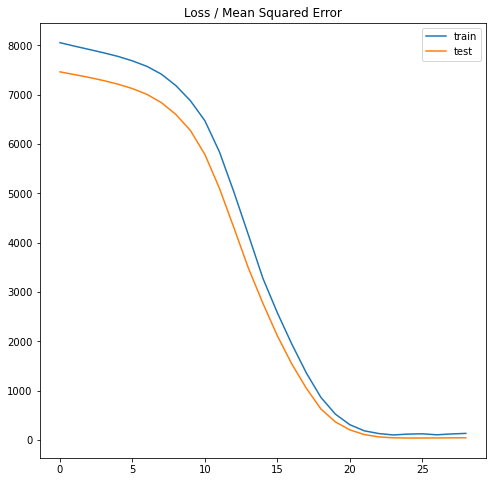

In [12]:
pyplot.figure(figsize=(8,8))
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [13]:
test_df[:21]

,location-long,location-lat
290,-123.140,37.667
291,-122.513,37.741
292,-123.055,37.716
293,-123.105,37.725
294,-123.265,37.712
295,-123.220,37.522
296,-123.032,37.607
297,-123.182,37.659
298,-122.890,37.546
299,-122.928,37.625


In [14]:
np.array([list(test.take(1).as_numpy_iterator())[0][0][0]]).shape

(1, 20, 2)

In [15]:
lstm_model.layers[0].input_shape

(None, 20, 2)

In [16]:
y_pred = lstm_model.predict(np.array([test_df[:20]]))[0]

In [17]:
y_pred

array([-119.71365 ,   34.967392], dtype=float32)

In [18]:
test_df.iloc[21]

location-long   -123.031
location-lat      37.511
Name: 311, dtype: float64

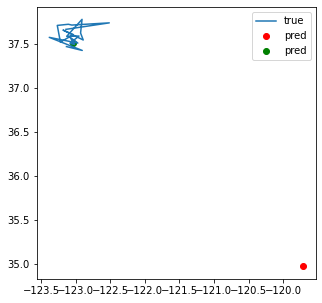

In [19]:
pyplot.figure(figsize=(5,5))
pyplot.plot(test_df[:20]["location-long"], test_df[:20]["location-lat"], label='true')
pyplot.scatter(y_pred[0], y_pred[1],  c="red", label='pred')
pyplot.scatter(test_df.iloc[21][0], test_df.iloc[21][1],  c="green", label='pred')
pyplot.legend()
pyplot.show()